In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load training and testing datasets
train_df = pd.read_csv("C:/Users/yasas/Desktop/fraudTrain.csv")
test_df = pd.read_csv("C:/Users/yasas/Desktop/fraudTest.csv")
train_df.drop(train_df.columns[0], axis=1, inplace=True)
test_df.drop(test_df.columns[0], axis=1, inplace=True)
df = pd.concat([train_df,test_df], axis = 0)
df

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555714,2020-12-31 23:59:07,30560609640617,fraud_Reilly and Sons,health_fitness,43.77,Michael,Olson,M,558 Michael Estates,Luray,...,40.4931,-91.8912,519,Town planner,1966-02-13,9b1f753c79894c9f4b71f04581835ada,1388534347,39.946837,-91.333331,0
555715,2020-12-31 23:59:09,3556613125071656,fraud_Hoppe-Parisian,kids_pets,111.84,Jose,Vasquez,M,572 Davis Mountains,Lake Jackson,...,29.0393,-95.4401,28739,Futures trader,1999-12-27,2090647dac2c89a1d86c514c427f5b91,1388534349,29.661049,-96.186633,0
555716,2020-12-31 23:59:15,6011724471098086,fraud_Rau-Robel,kids_pets,86.88,Ann,Lawson,F,144 Evans Islands Apt. 683,Burbank,...,46.1966,-118.9017,3684,Musician,1981-11-29,6c5b7c8add471975aa0fec023b2e8408,1388534355,46.658340,-119.715054,0
555717,2020-12-31 23:59:24,4079773899158,fraud_Breitenberg LLC,travel,7.99,Eric,Preston,M,7020 Doyle Stream Apt. 951,Mesa,...,44.6255,-116.4493,129,Cartographer,1965-12-15,14392d723bb7737606b2700ac791b7aa,1388534364,44.470525,-117.080888,0


In [3]:
sample_size = 0.15  
# Performing stratified sampling
d, _ = train_test_split(train_df, test_size=1-sample_size, stratify=train_df['is_fraud'], random_state=42)
# Displaying the sampled DataFrame
d.shape

(194501, 22)

In [4]:
def df_explore(df):
    missing = pd.DataFrame((df.isna().sum()/df.shape[0])*100).reset_index().rename(columns={'index': 'column',0:'%_missing'}).sort_values(by = '%_missing',ascending=False)
    nunique = pd.DataFrame(df.nunique()).reset_index().rename(columns={'index': 'column',0:'nunique'}).sort_values(by = 'nunique',ascending=False)
    dtypes = pd.DataFrame(df.dtypes).reset_index().rename(columns={'index': 'column',0:'dtype'})
    return pd.merge(pd.merge(dtypes,missing,on='column'),nunique,on='column',how='left').sort_values(by='%_missing',ascending=False).sort_values(by = 'nunique', ascending = False)
# print(d.shape)
df_explore(d).head(10)

,column,dtype,%_missing,nunique
17,trans_num,object,0.0,194501
20,merch_long,float64,0.0,194042
18,unix_time,int64,0.0,194009
0,trans_date_trans_time,object,0.0,194008
19,merch_lat,float64,0.0,193373
4,amt,float64,0.0,26167
1,cc_num,int64,0.0,968
8,street,object,0.0,968
11,zip,int64,0.0,957
13,long,float64,0.0,956


Data Balance Check¶

Text(0.5, 1.0, '% of Fraudulent vs Non-fraudulent transactions')

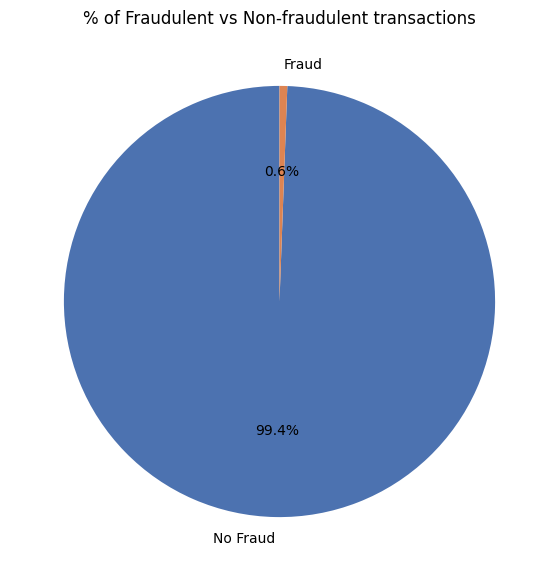

In [5]:
d['is_fraud_cat'] = d['is_fraud'].apply(lambda x: "Fraud" if x==1 else "No Fraud")

is_fraud_values = d['is_fraud_cat'].value_counts()

plt.figure(figsize=(7,7))
plt.pie(is_fraud_values, labels=is_fraud_values.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("deep", n_colors=len(is_fraud_values)))
plt.title('% of Fraudulent vs Non-fraudulent transactions')

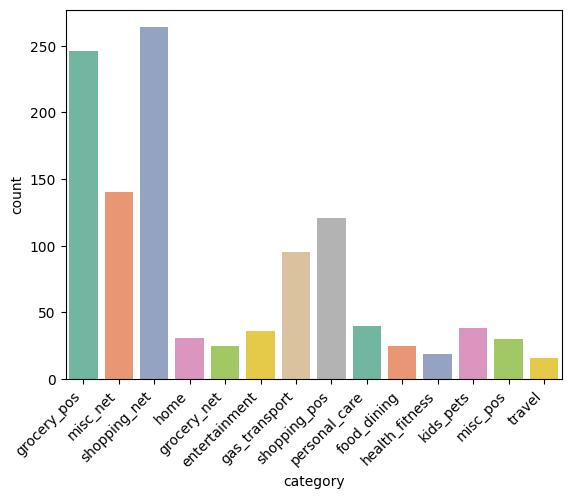

In [6]:
sns.countplot(x="category", data=d[d['is_fraud_cat']=="Fraud"], palette="Set2", hue = 'category')
plt.xticks(rotation=45, ha = 'right')
plt.show()

Data Pre-processing

Dropping duplicated values

In [7]:
df2 = d.copy()

df2.drop_duplicates(inplace=True)

print("Duplicated values dropped")

Duplicated values dropped


In [8]:
df2

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,is_fraud_cat
398918,2019-06-30 18:37:50,377654590313960,fraud_Bode-Schuster,kids_pets,55.05,Lawrence,Davis,M,7421 Serrano Lane Apt. 580,Powell,...,-84.0400,25459,"Teacher, special educational needs",1969-02-22,2b362b0b448963092065fb8e6c38ce8d,1341081470,36.175640,-84.646341,0,No Fraud
655541,2019-10-06 12:02:58,4956828990005111019,fraud_Block Group,misc_pos,3.03,Kenneth,Robinson,M,269 Sanchez Rapids,Elizabeth,...,-74.2239,124967,Operational researcher,1980-12-21,6387314112483e8206f351961340d7ce,1349524978,40.939505,-74.256242,0,No Fraud
911788,2019-12-29 10:56:07,4788103653396,fraud_Nienow PLC,entertainment,139.01,Kristin,Williams,F,36366 Smith Road,Miamisburg,...,-84.2675,36784,"Investment banker, corporate",1941-07-31,aa1d02f505bae2761149afd24ec4d72d,1356778567,39.822635,-84.105583,0,No Fraud
86389,2019-02-20 04:55:42,377264520876399,fraud_Bernhard Inc,gas_transport,55.74,Kara,Miles,F,2076 Thomas Roads Suite 970,Cassatt,...,-80.5000,4424,Lawyer,1961-07-31,e4e7b653235656a211fe759f1abf5cba,1329713742,34.962050,-80.168628,0,No Fraud
289156,2019-05-22 09:41:58,4155021259183870,fraud_Doyle Ltd,grocery_pos,93.78,Renee,Parrish,F,174 Jennifer Meadow Apt. 467,Mountain Park,...,-98.9591,540,Research scientist (life sciences),1983-10-12,9acd65e2601946fc132a9d64df5178ff,1337679718,34.068722,-98.940711,0,No Fraud
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1084904,2020-03-26 22:03:48,4560004149983868183,"fraud_Kihn, Brakus and Goyette",personal_care,38.94,Stacy,Villegas,F,20581 Pena Walks,Colorado Springs,...,-104.6556,525713,Museum/gallery exhibitions officer,1992-05-09,f93f924d08a19064ec37de7a69cf8e4b,1364335428,38.648246,-104.969889,0,No Fraud
78785,2019-02-16 14:20:54,378904938837132,fraud_Gerhold LLC,home,29.43,Tina,Zimmerman,F,3595 Susan Island Suite 063,Thomas,...,-98.7388,1675,Barrister,1986-05-01,12177fa4ce00fc361366c28e0af96b81,1329402054,35.110496,-98.246154,0,No Fraud
1151888,2020-04-25 18:11:52,4169759661243568,fraud_Abernathy and Sons,food_dining,64.98,Jamie,Carr,F,55363 Aaron Circle Suite 450,Lawn,...,-76.5380,213,Special educational needs teacher,1972-02-15,2a12827950e508d617add087df49687a,1366913512,40.191038,-77.350918,0,No Fraud
382538,2019-06-24 14:53:14,4155021259183870,fraud_Stark-Batz,entertainment,3.49,Renee,Parrish,F,174 Jennifer Meadow Apt. 467,Mountain Park,...,-98.9591,540,Research scientist (life sciences),1983-10-12,4a248f9b8268ba53241625b4af2a271c,1340549594,35.135938,-98.112255,0,No Fraud


Transforming Variables

In [9]:
def gender_transform(x):
    if x=='F':
        return 1
    if x=='M':
        return 0
df2['gender'] = df2['gender'].transform(gender_transform)
df3 = df2.drop(['unix_time','trans_date_trans_time','cc_num','trans_num','street','dob','city','merchant','job','last','first','state','is_fraud_cat'],axis = 1)

In [10]:
df3

,category,amt,gender,zip,lat,long,city_pop,merch_lat,merch_long,is_fraud
398918,kids_pets,55.05,0,37849,36.0435,-84.0400,25459,36.175640,-84.646341,0
655541,misc_pos,3.03,0,7208,40.6747,-74.2239,124967,40.939505,-74.256242,0
911788,entertainment,139.01,1,45342,39.6321,-84.2675,36784,39.822635,-84.105583,0
86389,gas_transport,55.74,1,29032,34.3424,-80.5000,4424,34.962050,-80.168628,0
289156,grocery_pos,93.78,1,73559,34.7032,-98.9591,540,34.068722,-98.940711,0
...,...,...,...,...,...,...,...,...,...,...
1084904,personal_care,38.94,1,80951,38.8881,-104.6556,525713,38.648246,-104.969889,0
78785,home,29.43,1,73669,35.7382,-98.7388,1675,35.110496,-98.246154,0
1151888,food_dining,64.98,1,17041,40.2236,-76.5380,213,40.191038,-77.350918,0
382538,entertainment,3.49,1,73559,34.7032,-98.9591,540,35.135938,-98.112255,0


 Dummy Variables

In [11]:
df3_dummies = pd.get_dummies(df3.select_dtypes('object'), dtype = int)
df4 = pd.concat([df3.drop(df3.select_dtypes('object').columns, axis = 1), df3_dummies],axis = 1)
print(df4.shape)
df4.head()

(194501, 23)


,amt,gender,zip,lat,long,city_pop,merch_lat,merch_long,is_fraud,category_entertainment,...,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel
398918,55.05,0,37849,36.0435,-84.0400,25459,36.175640,-84.646341,0,0,...,0,0,0,1,0,0,0,0,0,0
655541,3.03,0,7208,40.6747,-74.2239,124967,40.939505,-74.256242,0,0,...,0,0,0,0,0,1,0,0,0,0
911788,139.01,1,45342,39.6321,-84.2675,36784,39.822635,-84.105583,0,1,...,0,0,0,0,0,0,0,0,0,0
86389,55.74,1,29032,34.3424,-80.5000,4424,34.962050,-80.168628,0,0,...,0,0,0,0,0,0,0,0,0,0
289156,93.78,1,73559,34.7032,-98.9591,540,34.068722,-98.940711,0,0,...,1,0,0,0,0,0,0,0,0,0


In [12]:
X = df4.reset_index(drop='index').drop('is_fraud', axis=1)

y = df4.reset_index(drop='index')['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.3, random_state = 42)

In [13]:
def Standard_Scaler (df, col_names):

    features = df[col_names]

    scaler = StandardScaler().fit(features.values)

    features = scaler.transform(features.values)

    df[col_names] = features

    return df

col_names = ['amt']

X_train = Standard_Scaler (X_train, col_names)

X_test = Standard_Scaler (X_test, col_names)

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200)

In [15]:
rf.fit(X_train, y_train)
y_pred_baseline = rf.predict(X_test)

In [16]:
print("Performance with imbalanced dataset:")
print(classification_report(y_test, y_pred_baseline))

Performance with imbalanced dataset:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     58013
           1       0.87      0.57      0.69       338

    accuracy                           1.00     58351
   macro avg       0.94      0.79      0.84     58351
weighted avg       1.00      1.00      1.00     58351



In [17]:
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
print(accuracy_score(y_test,y_pred_baseline))

0.9970351836301006


In [18]:
cm = confusion_matrix(y_test, y_pred_baseline)
rf_baseline_Recall = recall_score(y_test, y_pred_baseline)
rf_baseline_Precision = precision_score(y_test, y_pred_baseline)
rf_baseline_f1 = f1_score(y_test, y_pred_baseline)
rf_baseline_accuracy = accuracy_score(y_test, y_pred_baseline)

ndf = [(rf_baseline_Recall, rf_baseline_Precision, rf_baseline_f1, rf_baseline_accuracy)]

rf_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
rf_score.insert(0, 'Random Forest performed with', 'Original (Imbalanced Dataset)')
rf_score

,Random Forest performed with,Recall,Precision,F1 Score,Accuracy
0,Original (Imbalanced Dataset),0.571006,0.873303,0.690519,0.997035


In [19]:
from imblearn.over_sampling import RandomOverSampler
# defining oversampling method
ros = RandomOverSampler(random_state=42)

rf_oversample = RandomForestClassifier(n_estimators=200)
X_train_oversample, y_train_oversample = ros.fit_resample(X_train, y_train)

In [20]:
rf_oversample.fit(X_train_oversample, y_train_oversample)
y_pred_oversample = rf_oversample.predict(X_test)

In [21]:
print(accuracy_score(y_test, y_pred_oversample))

0.9968466692944422


In [22]:
cm = confusion_matrix(y_test, y_pred_oversample)

oversample_rf_Recall = recall_score(y_test, y_pred_oversample)
oversample_rf_Precision = precision_score(y_test, y_pred_oversample)
oversample_rf_f1 = f1_score(y_test, y_pred_oversample)
oversample_rf_accuracy = accuracy_score(y_test, y_pred_oversample)

ndf_over = [(oversample_rf_Recall, oversample_rf_Precision, oversample_rf_f1, oversample_rf_accuracy)]

oversample_rf_score = pd.DataFrame(data = ndf_over, columns=['Recall','Precision','F1 Score', 'Accuracy'])
oversample_rf_score.insert(0, 'Random Forest performed with', 'Random Oversampling')
oversample_rf_score

,Random Forest performed with,Recall,Precision,F1 Score,Accuracy
0,Random Oversampling,0.639053,0.776978,0.701299,0.996847


In [23]:
from imblearn.under_sampling import RandomUnderSampler
# defining oversampling method
rus = RandomUnderSampler(random_state=42)

rf_undersample = RandomForestClassifier(n_estimators=200)
X_train_undersample, y_train_undersample = rus.fit_resample(X_train, y_train)

In [24]:
rf_undersample.fit(X_train_undersample, y_train_undersample)
y_pred_undersample = rf_undersample.predict(X_test)

In [25]:
cm = confusion_matrix(y_test, y_pred_undersample)

undersample_rf_Recall = recall_score(y_test, y_pred_undersample)
undersample_rf_Precision = precision_score(y_test, y_pred_undersample)
undersample_rf_f1 = f1_score(y_test, y_pred_undersample)
undersample_rf_accuracy = accuracy_score(y_test, y_pred_undersample)

ndf_over = [(undersample_rf_Recall, undersample_rf_Precision, undersample_rf_f1, undersample_rf_accuracy)]

undersample_rf_score = pd.DataFrame(data = ndf_over, columns=['Recall','Precision','F1 Score', 'Accuracy'])
undersample_rf_score.insert(0, 'Random Forest performed with', 'Random Undersampling')
undersample_rf_score

,Random Forest performed with,Recall,Precision,F1 Score,Accuracy
0,Random Undersampling,0.928994,0.110563,0.197609,0.956299


In [26]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
rf_smote = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [27]:
rf_smote.fit(X_train_smote,y_train_smote)
y_pred_smote = rf_smote.predict(X_test)

In [28]:
print("Performance with SMOTE:")
print(classification_report(y_test, y_pred_smote))

Performance with SMOTE:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     58013
           1       0.11      0.76      0.19       338

    accuracy                           0.96     58351
   macro avg       0.55      0.86      0.58     58351
weighted avg       0.99      0.96      0.98     58351



In [29]:
cm_smote = confusion_matrix(y_test, y_pred_smote)
rf_smote_Recall = recall_score(y_test, y_pred_smote)
rf_smote_Precision = precision_score(y_test, y_pred_smote)
rf_smote_f1 = f1_score(y_test, y_pred_smote)
rf_smote_accuracy = accuracy_score(y_test, y_pred_smote)

ndf = [(rf_smote_Recall, rf_smote_Precision, rf_smote_f1, rf_smote_accuracy)]

rf_smote_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
rf_smote_score.insert(0, 'Random Forest performed with', 'Smote Oversampling')
rf_smote_score

,Random Forest performed with,Recall,Precision,F1 Score,Accuracy
0,Smote Oversampling,0.763314,0.108085,0.189358,0.962143


In [30]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
SMOTETomek = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
rf_SMOTETomek = RandomForestClassifier(n_estimators=200)
X_train_SMOTETomek, y_train_SMOTETomek = SMOTETomek.fit_resample(X_train, y_train)

In [31]:
rf_SMOTETomek.fit(X_train_SMOTETomek,y_train_SMOTETomek)
y_pred_SMOTETomek = rf_SMOTETomek.predict(X_test)

In [32]:
print("Performance with SMOTE:")
print(classification_report(y_test, y_pred_SMOTETomek))

Performance with SMOTE:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     58013
           1       0.79      0.63      0.70       338

    accuracy                           1.00     58351
   macro avg       0.90      0.82      0.85     58351
weighted avg       1.00      1.00      1.00     58351



In [33]:
cm_smote_tomek = confusion_matrix(y_test, y_pred_SMOTETomek)
rf_smote_tomek_Recall = recall_score(y_test, y_pred_SMOTETomek)
rf_smote_tomek_Precision = precision_score(y_test, y_pred_SMOTETomek)
rf_smote_tomek_f1 = f1_score(y_test, y_pred_SMOTETomek)
rf_smote_tomek_accuracy = accuracy_score(y_test, y_pred_SMOTETomek)

ndf = [(rf_smote_tomek_Recall, rf_smote_tomek_Precision, rf_smote_tomek_f1, rf_smote_tomek_accuracy)]

rf_smote_tomek_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
rf_smote_tomek_score.insert(0, 'Random Forest performed with', 'SMOTE & Tomek')
rf_smote_tomek_score

,Random Forest performed with,Recall,Precision,F1 Score,Accuracy
0,SMOTE & Tomek,0.633136,0.792593,0.703947,0.996915


In [34]:
rf_sampling_scores = pd.concat([rf_score, oversample_rf_score, undersample_rf_score,rf_smote_score, rf_smote_tomek_score],axis = 0)
rf_sampling_scores

,Random Forest performed with,Recall,Precision,F1 Score,Accuracy
0,Original (Imbalanced Dataset),0.571006,0.873303,0.690519,0.997035
0,Random Oversampling,0.639053,0.776978,0.701299,0.996847
0,Random Undersampling,0.928994,0.110563,0.197609,0.956299
0,Smote Oversampling,0.763314,0.108085,0.189358,0.962143
0,SMOTE & Tomek,0.633136,0.792593,0.703947,0.996915


In [35]:
accuracy = accuracy_score(y_test, y_pred_undersample)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

Model Accuracy: 95.63%


In [36]:
class_names = {1:'Fraud',0:'No Fraud'}
predicted_classes = [class_names[label] for label in y_pred_undersample]

# Mapping true labels to custom class names
class_map = [class_names[label] for label in y_test]

# Step 10: Print the predicted and actual class names for the first 5 test samples
for i in range(20):
    print(f"Sample {i+1}: True Class: {class_map[i]}, Predicted Class: {predicted_classes[i]}")

Sample 1: True Class: No Fraud, Predicted Class: No Fraud
Sample 2: True Class: No Fraud, Predicted Class: No Fraud
Sample 3: True Class: No Fraud, Predicted Class: No Fraud
Sample 4: True Class: No Fraud, Predicted Class: No Fraud
Sample 5: True Class: No Fraud, Predicted Class: No Fraud
Sample 6: True Class: No Fraud, Predicted Class: No Fraud
Sample 7: True Class: No Fraud, Predicted Class: No Fraud
Sample 8: True Class: No Fraud, Predicted Class: No Fraud
Sample 9: True Class: No Fraud, Predicted Class: No Fraud
Sample 10: True Class: No Fraud, Predicted Class: No Fraud
Sample 11: True Class: No Fraud, Predicted Class: No Fraud
Sample 12: True Class: No Fraud, Predicted Class: No Fraud
Sample 13: True Class: No Fraud, Predicted Class: No Fraud
Sample 14: True Class: No Fraud, Predicted Class: No Fraud
Sample 15: True Class: No Fraud, Predicted Class: No Fraud
Sample 16: True Class: No Fraud, Predicted Class: No Fraud
Sample 17: True Class: No Fraud, Predicted Class: No Fraud
Sample

In [37]:
fraud_count = predicted_classes.count('Fraud')
no_fraud_count = predicted_classes.count('No Fraud')

In [38]:
print(fraud_count,no_fraud_count)

2840 55511
